# NEST SIMULATION     

## 0. LIBRARIES

### 0.1 Regular Libraries

In [1]:
import nest
import matplotlib.pyplot as plt
import csv
from random import randrange


              -- N E S T --
  Copyright (C) 2004 The NEST Initiative

 Version: nest-3.1
 Built: Sep 28 2021 11:43:45

 This program is provided AS IS and comes with
 NO WARRANTY. See the file LICENSE for details.

 Problems or suggestions?
   Visit https://www.nest-simulator.org

 Type 'nest.help()' to find out more about NEST.



### 0.2 Functions created by me

In [2]:
from getData import *
from plot import *

## 1. IMPORTING DATA

### 1.1 Info about the Network

In [3]:
positions_list = getNeuronPositions('net_1000')

synaptic_matrix = getSynapses('net_1000')

input_matrix = getInput('net_1000', 1000)

neuron_IDs = getNeuronMatrix('net_1000')

### 1.2 Parameters

Model parameters computed from data extracted from .json and .swc files

In [4]:
file = open("/home/ubuntu/BasalGanglia/NEST-params/dspn_params.csv")
csvreader = csv.reader(file)
dspn_params = []
for row in csvreader:
    res = [float(value) for value in row[0].split(';')]    
    dspn_params.append(res)
file.close()

file = open("/home/ubuntu/BasalGanglia/NEST-params/ispn_params.csv")
csvreader = csv.reader(file)
ispn_params = []
for row in csvreader:
    res = [float(value) for value in row[0].split(';')]
    ispn_params.append(res)
file.close()

file = open("/home/ubuntu/BasalGanglia/NEST-params/fs_params.csv")
csvreader = csv.reader(file)
fs_params = []
for row in csvreader:
    res = [float(value) for value in row[0].split(';')]
    fs_params.append(res)
file.close()

chin_params = [[11.65139394,-50,194.5705]]

lts_params = [[1.259667491,-46.06675265,85.9879]]

### 2. CREATING THE NEST NETWORK

### 2.1 Creating the Neurons

Here we create a position list, with the coordinates of each neuron of the network.
(This first step is not necessary, since the spatial distribution of the network does not influence the NEST simulation.)

In [5]:
pos = nest.spatial.free(positions_list) # using NEURON positions

Now we create all the neurons at once, with same characteristics. They are all conductance based integrate and fire model, with the default parameters of nest.\

In [6]:
s_nodes = nest.Create("iaf_cond_alpha", 999, positions=pos) 

In [7]:
#creating the parameter arrays for g_L, e_L and c_M
gL = []
eL = []
Cm = []

for i in range (0, len(neuron_IDs)):
    
    #retrieves neuron type
    neuron_type = neuron_IDs[i][1]
        
    if (neuron_type == 'dspn'):
        
        #randomly selects one of the sets of parameters for dspn
        index = randrange(len(dspn_params))
        
        gL.append(dspn_params[index][0])
        eL.append(dspn_params[index][1])
        Cm.append(dspn_params[index][2])
                
    elif (neuron_type == 'ispn'):
        
        #randomly selects one of the sets of parameters for dspn
        index = randrange(len(ispn_params))
        
        gL.append(ispn_params[index][0])
        eL.append(ispn_params[index][1])
        Cm.append(ispn_params[index][2])
                
        
    elif (neuron_type == 'fs'):
        
        #randomly selects one of the sets of parameters for dspn
        index = randrange(len(fs_params))
        
        gL.append(fs_params[index][0])
        eL.append(fs_params[index][1])
        Cm.append(fs_params[index][2])
            
    elif (neuron_type == 'lts'):
        #randomly selects one of the sets of parameters for dspn
        index = randrange(len(lts_params))
        
        gL.append(lts_params[index][0])
        eL.append(lts_params[index][1])
        Cm.append(lts_params[index][2])

    elif (neuron_type == 'chin'):
        #randomly selects one of the sets of parameters for dspn
        index = randrange(len(chin_params))
        
        gL.append(chin_params[index][0])
        eL.append(chin_params[index][1])
        Cm.append(chin_params[index][2])        


In [8]:
s_nodes.set({'g_L': gL, 'E_L': eL, 'C_m': Cm})

With the info of the synaptic matrix, we create the pre-synaptic as post-synaptic neuron ID lists, and transform them into numpy arrays

In [9]:
pre_list = []
pos_list = []

for i in range(0,len(synaptic_matrix)):
    pre_list.append(s_nodes[synaptic_matrix[i][0]])
    pos_list.append(s_nodes[synaptic_matrix[i][1]])
    
pre_array = np.transpose(np.array(pre_list)).flatten()
pos_array = np.transpose(np.array(pos_list)).flatten()

With the arrays ready, we can connect the synapses all in one command.
(again here, if we wish to have different parameters and arguments for each synapse, a more complex solution is necessary.)

In [10]:
syn_matrix = old_getWeightedSynapses(pre_array,pos_array)

[[  1   2   4]
 [  1   6   3]
 [  1   7   4]
 ...
 [999 976   3]
 [999 996   5]
 [999 997   4]]


In [11]:
syn_wgt = [] 
conductances = []
for i in range(0,len(syn_matrix)):
    
    neuron_type = neuron_IDs[syn_matrix[i][0]-1][1]
        
    if (neuron_type == 'dspn' or neuron_type == 'ispn' ):
        #"conductance": [2.4e-10, 1e-10]
        cond = np.random.normal(2.4e-10,  1e-10, 1)
        
        if(cond<2.4e-11): #capping at 10% of mean
            cond = 2.4e-11
    elif (neuron_type == 'lts'):
        # conductance mean = 3e-09, std deviation =  0
        cond = 3e-09
        
    elif (neuron_type == 'fs'):
        #"conductance": [1.1e-09, 1.5e-09],
        cond = np.random.normal(1.1e-09, 1.5e-09, 1)
        
        if(cond<1.1e-10): #capping at 10% of mean
            cond = 1.1e-10
    
    conductances.append(cond)   

In [12]:
weights = []
for i in range(0, len(conductances)):
    weights.append(-1*conductances[i]*syn_matrix[i][2])
weights = np.row_stack(weights).flatten()

In [13]:
sources = syn_matrix[:,0]
targets = syn_matrix[:,1]

In [14]:
nest.Connect(sources,targets,conn_spec= "one_to_one", syn_spec= {"weight": weights})

Now onto the creation of the Spike Generators.

In [15]:
inputs = nest.Create("spike_generator", 999)

In [16]:
for g, generator in enumerate(inputs):
    
    #spk_wgt = np.full(len(input_matrix[g]), 2.0)
    #nest.SetStatus(generator, {"spike_times": input_matrix[g], "spike_weights": spk_wgt})
    nest.SetStatus(generator, {"spike_times": input_matrix[g]})

In [17]:
spikerecorder = nest.Create("spike_recorder")

In [18]:
input_syn_wgt = np.full(len(inputs), 4.0)
nest.Connect(inputs,s_nodes, conn_spec= "one_to_one", syn_spec={"weight": input_syn_wgt})

In [19]:
nest.Connect(s_nodes,spikerecorder, conn_spec= "all_to_all")

In [20]:
multimeter = nest.Create("multimeter")
multimeter.set(record_from=["V_m"])
nest.Connect(multimeter,s_nodes, "all_to_all")

In [21]:
mult1 = nest.Create("multimeter", 5)
mult1.set(record_from=["V_m"])
chosen_nodes = [1,11,21,31,41]
nest.Connect(mult1,chosen_nodes, "one_to_one")

### RUNNING THE SIMULATION
Here we are using a total run itme of 2000 ms (and the default step of simulation of 0.1 ms)

In [22]:
nest.Simulate(2000.0)


Nov 18 15:50:25 NodeManager::prepare_nodes [Info]: 
    Preparing 2005 nodes for simulation.

Nov 18 15:50:25 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 2005
    Simulation time (ms): 2000
    Number of OpenMP threads: 1
    Number of MPI processes: 1

Nov 18 15:50:33 SimulationManager::run [Info]: 
    Simulation finished.


### ANALYSING THE RESULTS

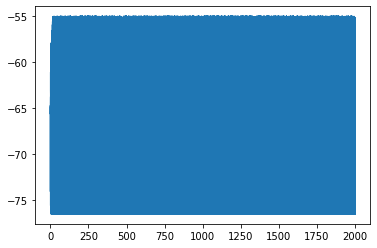

In [23]:
dmm = multimeter.get()
Vms = dmm["events"]["V_m"]
ts = dmm["events"]["times"]
ids = dmm["events"]["senders"]

plt.figure(1)
plt.plot(ts, Vms)
plt.show()

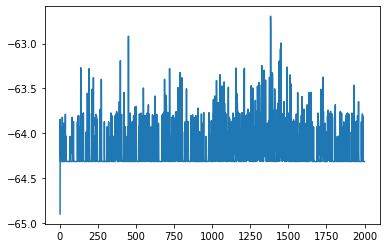

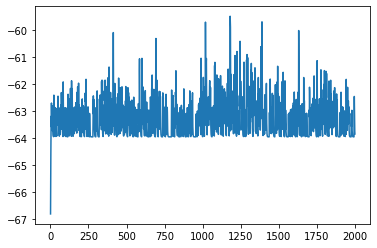

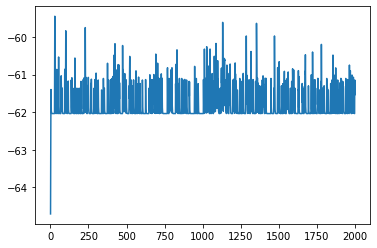

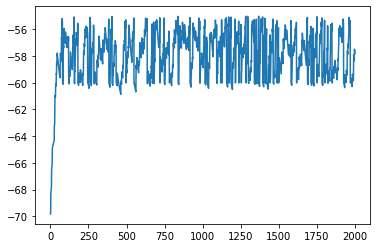

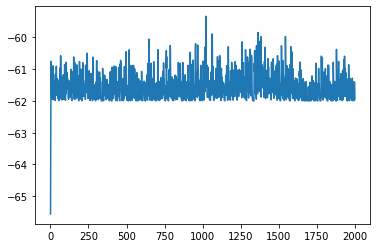

In [24]:
for i in range(0,5):
    dmm1 = mult1[i].get()
    Vms1 = dmm1["events"]["V_m"]
    ts1 = dmm1["events"]["times"]
    ids1 = dmm1["events"]["senders"]

    plt.figure(1)
    plt.plot(ts1, Vms1)
    plt.show()

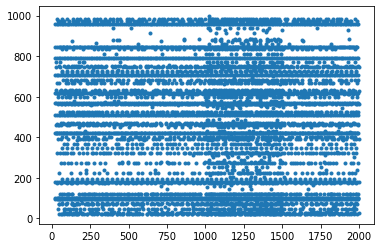

In [25]:
dSD = spikerecorder.get("events")
evs = dSD["senders"]
ts = dSD["times"]
plt.figure(2)
plt.plot(ts, evs, ".")
plt.show()

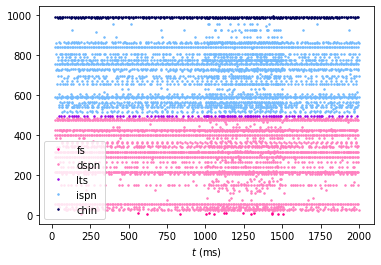

In [26]:
spikes = {}

for i in range(0, len(evs)) :

    nID = evs[i]
    spike_time = ts[i]
    if(nID not in spikes.keys()):
        spikes[nID] = []            
    spikes[nID].append(spike_time)

for i in range(0, 1000):
    if(i not in spikes.keys()):
        spikes[i] = []

chin_color='xkcd:dark blue'
ispn_color='xkcd:sky blue'
lts_color='xkcd:violet'
dspn_color='xkcd:pink'
fs_color='xkcd:hot pink'

n_ids = np.array(list(spikes.keys()), dtype=int)
n_ids.sort() #organize the neurons by id

dspn_ID, ispn_ID, lts_ID, fs_ID, chin_ID = getNeuronSubMatrixes(neuron_IDs)

orderedIDs = getOrderedIDs(dspn_ID, ispn_ID, lts_ID, fs_ID, chin_ID)


fig_handle = plt.figure()
ax = fig_handle.add_subplot(111)
ax.set_xlabel('$t$ (ms)')

plotSpikes(spikes, fs_ID, orderedIDs, fs_color, 'fs', ax)
plotSpikes(spikes, dspn_ID, orderedIDs,dspn_color, 'dspn', ax)
plotSpikes(spikes, lts_ID, orderedIDs, lts_color, 'lts', ax)
plotSpikes(spikes, ispn_ID, orderedIDs,ispn_color , 'ispn', ax)
plotSpikes(spikes, chin_ID, orderedIDs, chin_color, 'chin', ax)

plt.legend()
plt.show()


In [27]:
d = {}
for key, val in evs, ts:
    d.setdefault(key, []).append(val)

print(d)

ValueError: too many values to unpack (expected 2)

In [ ]:
print(spk_dict.get(92))

### OTHERS

In [ ]:
def plotRaster(folder_path, size):
    ''' Given a path to a folder inside NEURON-data, generates the raster plot for the corresponding simulation
        (folder_path is "NEURON-data/net_X" )
    '''    
    spikes_dict = getSpikes(folder_path, size)
    
    n_ids = np.array(list(spikes_dict.keys()), dtype=int)
    n_ids.sort() #organize the neurons by id

    neuron_matrix = getNeuronMatrix(folder_path)
    dspn_ID, ispn_ID, lts_ID, fs_ID, chin_ID = getNeuronSubMatrixes(neuron_matrix)
    
    orderedIDs = getOrderedIDs(dspn_ID, ispn_ID, lts_ID, fs_ID, chin_ID)


    fig_handle = plt.figure()
    ax = fig_handle.add_subplot(111)
    ax.set_xlabel('$t$ (ms)')

    plotSpikes(spikes_dict, fs_ID, orderedIDs, fs_color, 'fs', ax)
    plotSpikes(spikes_dict, dspn_ID, orderedIDs,dspn_color, 'dspn', ax)
    plotSpikes(spikes_dict, lts_ID, orderedIDs, lts_color, 'lts', ax)
    plotSpikes(spikes_dict, ispn_ID, orderedIDs,ispn_color , 'ispn', ax)
    plotSpikes(spikes_dict, chin_ID, orderedIDs, chin_color, 'chin', ax)


    plt.legend()
    plt.show()
